In [1]:
!pip install -qq llama-index
!pip install -qq faiss-cpu
!pip install -qq git+https://github.com/openai/CLIP.git
!pip install -qq llama-index-embeddings-clip
!pip install -qq transformers 
!pip install -qq accelerate

In [2]:
!pip install -qq llama-index-vector-stores-lancedb
!pip install -qq llama-index-vector-stores-faiss

In [3]:
import os
import faiss
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from transformers import pipeline
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import (
    SimpleDirectoryReader,
    load_index_from_storage,
    VectorStoreIndex,
    StorageContext,
)
from llama_index.vector_stores.faiss import FaissVectorStore

c:\Users\bhakt\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\bhakt\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [4]:
from llama_index.core import SimpleDirectoryReader, StorageContext
# from llama_index.vector_stores.faiss import FaissVectorStore
from llama_index.core.schema import ImageNode

In [5]:
# Initialize CLIP model for image embeddings
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, T5ForConditionalGeneration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

flan_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small").to(device)
flan_tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

In [6]:
from llama_index.core.schema import ImageDocument
from llama_index.core.embeddings import BaseEmbedding
from typing import List, Any
from pydantic import Field

class CLIPEmbedding(BaseEmbedding):
    model: Any = Field(default=None)
    processor: Any = Field(default=None)

    def __init__(self, model=None, processor=None):
        super().__init__()
        self.model = model or clip_model
        self.processor = processor or clip_processor

    def _get_query_embedding(self, query: str) -> List[float]:
        inputs = self.processor(text=[query], return_tensors="pt", padding=True)
        with torch.no_grad():
            text_embeds = self.model.get_text_features(**inputs)
        return text_embeds.squeeze().tolist()

    def _get_text_embedding(self, text: str) -> List[float]:
        return self._get_query_embedding(text)

    def _get_image_embedding(self, image_path: str) -> List[float]:
        image = Image.open(image_path).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        with torch.no_grad():
            image_embeds = self.model.get_image_features(**inputs)
        return image_embeds.squeeze().tolist()

    def _aget_query_embedding(self, query: str) -> List[float]:
        """Get query embedding for asynchronous calls."""
        return self._get_query_embedding(query)


def get_image_embedding(image_path):
    """Function to get CLIP image embeddings."""
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_embeds = clip_model.get_image_features(**inputs)
    return image_embeds.squeeze().numpy()

def get_image_metadata(image_path):
    """Extract basic metadata from image (file path, dimensions)."""
    with Image.open(image_path) as img:
        metadata = {
            "file_path": image_path,
            "size": img.size,
            "mode": img.mode,
        }
    return metadata

def create_image_documents(image_paths):
    """Create ImageDocument objects with associated metadata and embeddings."""
    image_documents = []
    for image_path in image_paths:
        if os.path.isfile(image_path):
            image_embedding = get_image_embedding(image_path)
            metadata = get_image_metadata(image_path)

            # Change here: Instead of passing the image object, pass the image_path
            image_document = ImageDocument(
                image_path=image_path,
                # image=Image.open(image_path),  # Remove or comment out this line
                metadata=metadata,
                embedding=image_embedding
            )
            image_documents.append(image_document)

    return image_documents

# Load image paths
image_path = "D:\Hacktober\image2\images"  # Adjust the path to your directory containing images
image_paths = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

clip_embed_model = CLIPEmbedding()

# Create ImageDocument objects
image_documents = create_image_documents(image_paths)

# Create FAISS index for image embeddings
embedding_dim = 512
faiss_index = faiss.IndexFlatL2(embedding_dim)

# Add embeddings to FAISS index
embeddings = [doc.embedding for doc in image_documents]
embeddings_np = np.vstack(embeddings).astype(np.float32)
faiss_index.add(embeddings_np)

# Initialize the FAISS vector store
image_store = FaissVectorStore(faiss_index=faiss_index)

# Create the storage context
storage_context = StorageContext.from_defaults(vector_store=image_store)

# Build the index from the image documents
index = MultiModalVectorStoreIndex.from_documents(
    image_documents,
    storage_context=storage_context,
    embed_model=CLIPEmbedding()
)

print("Index created successfully!")

<>:74: SyntaxWarning: invalid escape sequence '\H'
<>:74: SyntaxWarning: invalid escape sequence '\H'
C:\Users\bhakt\AppData\Local\Temp\ipykernel_2636\2761028217.py:74: SyntaxWarning: invalid escape sequence '\H'
  image_path = "D:\Hacktober\image2\images"  # Adjust the path to your directory containing images


Index created successfully!


In [7]:
# Define a query related to image content
query = "Find an image related to multihead attention"

# Set up the retriever for image similarity search (adjust the top_k to get top similar images)
retriever = index.as_retriever(image_similarity_top_k=1)

# Perform retrieval based on the query using Dolly v2
retrieval_results = retriever.retrieve(query)

In [8]:
# Function to display retrieved images and their metadata
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])  # Hide x-axis
            plt.yticks([])  # Hide y-axis

            images_shown += 1
            if images_shown >= 9:  # Limit to displaying 9 images
                break

Highest Scored ImageNode
-----------------------
File Path: D:\Hacktober\image2\images\transformer.png
Dimensions: (850, 1195)
Mode: RGBA


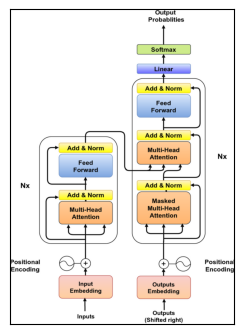

In [9]:
# Collect the retrieved image paths and display metadata
retrieved_image_paths = []

for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        print("Highest Scored ImageNode")
        print("-----------------------")
        metadata = res_node.node.metadata
        print(f"File Path: {metadata['file_path']}")
        print(f"Dimensions: {metadata['size']}")
        print(f"Mode: {metadata['mode']}")
        retrieved_image_paths.append(metadata["file_path"])

# Plot the retrieved images
plot_images(retrieved_image_paths)

In [10]:
from transformers import AutoTokenizer

# Initialize the tokenizer with the appropriate model name
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")  # Or another Flan-T5 variant

# Now you can use the 'tokenizer' object to process text
# Example:
input_ids = tokenizer(query, return_tensors="pt").input_ids

In [11]:
# Example of using Dolly v2 for text generation (LLM)
print("Flan T5 text generation example:")
# Assuming flan_model is your T5ForConditionalGeneration object and tokenizer is initialized
input_ids = tokenizer(query, return_tensors="pt").input_ids
response = flan_model.generate(input_ids, max_length=100, do_sample=True)
response_text = tokenizer.decode(response[0], skip_special_tokens=True)
print(response_text)

Flan T5 text generation example:
image titled multihead attention
